In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import TimestampType
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
plt.rc("axes", axisbelow=True)

import os

spark = SparkSession.builder.getOrCreate()

22/08/17 08:43:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# Reading csv file
olist_orders_dataset = spark.read.options(header='True', inferSchema='True', delimiter=',') \
                            .csv("ecommerce_data/olist_orders_dataset.csv")

In [3]:
orders_date = olist_orders_dataset.select("order_id","order_estimated_delivery_date","order_delivered_customer_date")
orders_date.show()

+--------------------+-----------------------------+-----------------------------+
|            order_id|order_estimated_delivery_date|order_delivered_customer_date|
+--------------------+-----------------------------+-----------------------------+
|e481f51cbdc54678b...|          2017-10-18 00:00:00|          2017-10-10 21:25:13|
|53cdb2fc8bc7dce0b...|          2018-08-13 00:00:00|          2018-08-07 15:27:45|
|47770eb9100c2d0c4...|          2018-09-04 00:00:00|          2018-08-17 18:06:29|
|949d5b44dbf5de918...|          2017-12-15 00:00:00|          2017-12-02 00:28:42|
|ad21c59c0840e6cb8...|          2018-02-26 00:00:00|          2018-02-16 18:17:02|
|a4591c265e18cb1dc...|          2017-08-01 00:00:00|          2017-07-26 10:57:55|
|136cce7faa42fdb2c...|          2017-05-09 00:00:00|                         null|
|6514b8ad8028c9f2c...|          2017-06-07 00:00:00|          2017-05-26 12:55:51|
|76c6e866289321a7c...|          2017-03-06 00:00:00|          2017-02-02 14:08:10|
|e69

In [4]:
orders_date = orders_date.withColumn('order_estimated_delivery_date',to_date(unix_timestamp \
            (orders_date.order_estimated_delivery_date, 'yyyy-MM-dd HH:mm:ss').cast('timestamp'))) \
                        .withColumn('order_delivered_customer_date',to_date(unix_timestamp \
            (orders_date.order_delivered_customer_date, 'yyyy-MM-dd HH:mm:ss').cast('timestamp')))

### Number of all orders: 99441

In [5]:
orders_date.count()

99441

### Null values in  "order_delivered_customer_date" column we treat as not delivered orders

In [6]:
# Checking missing values
print(f"Null values in column order_id: {orders_date.where(F.col('order_id').isNull()).count()}")
print(f"Null values in column order_estimated_delivery_date: {orders_date.where(F.col('order_estimated_delivery_date').isNull()).count()}")
print(f"Null values in column order_delivered_customer_date: {orders_date.where(F.col('order_delivered_customer_date').isNull()).count()}")

Null values in column order_id: 0
Null values in column order_estimated_delivery_date: 0
Null values in column order_delivered_customer_date: 2965


### The number of never orders is 2965, which is 3% of all orders

In [7]:
print(f"Number of undelivered orders: {orders_date.where(F.col('order_delivered_customer_date').isNull()).count()}")
print(f"Percentage of undelivered orders: {orders_date.where(F.col('order_delivered_customer_date').isNull()).count()/orders_date.count()*100}")

Number of undelivered orders: 2965
Percentage of undelivered orders: 2.981667521444877


In [8]:
delayed_orders = orders_date.select("order_id","order_estimated_delivery_date","order_delivered_customer_date") \
            .filter(orders_date.order_estimated_delivery_date < orders_date.order_delivered_customer_date)

### Delayed Orders
Delayed orders do not include orders that have not been delivered

In [9]:
delayed_orders.show()

+--------------------+-----------------------------+-----------------------------+
|            order_id|order_estimated_delivery_date|order_delivered_customer_date|
+--------------------+-----------------------------+-----------------------------+
|203096f03d82e0dff...|                   2017-09-28|                   2017-10-09|
|fbf9ac61453ac646c...|                   2018-03-12|                   2018-03-21|
|6ea2f835b4556291f...|                   2017-12-21|                   2017-12-28|
|66e4624ae69e7dc89...|                   2018-04-02|                   2018-04-03|
|a685d016c8a26f71a...|                   2017-03-30|                   2017-04-06|
|6a0a8bfbbe700284f...|                   2017-12-11|                   2017-12-28|
|a5474c0071dd5d107...|                   2018-08-02|                   2018-08-03|
|9d531c565e28c3e0d...|                   2017-12-22|                   2018-01-23|
|8fc207e94fa91a764...|                   2017-12-19|                   2018-01-20|
|33a

### The number of delayed orders is 6535, which is 6.5% of all orders

In [10]:
print(f"orders delayed orders: {delayed_orders.count()}")
print(f"Procent delayed orders: {delayed_orders.count()/orders_date.count()*100}")

orders delayed orders: 6535
Procent delayed orders: 6.571736004263835


### The number of undelivered & delayed orders is 9500, which is 9.5% of all orders

In [11]:
print(f"Number of undelivered & delayed orders: {orders_date.where(F.col('order_delivered_customer_date').isNull()).count()+delayed_orders.count()}")
print(f"Percent of undelivered & delayed orders: {(orders_date.where(F.col('order_delivered_customer_date').isNull()).count()+delayed_orders.count())/orders_date.count()*100}")

Number of undelivered & delayed orders: 9500
Percent of undelivered & delayed orders: 9.553403525708712


### Make a schedule chart for all & delayed orders

In [12]:
#  preparing directory for plots
try:
    os.mkdir("plots")
except OSError as error:
    pass

## 

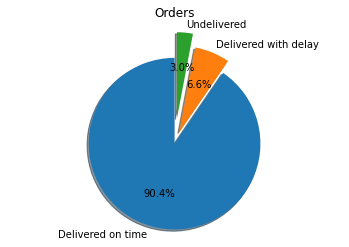

In [13]:
labels_ud = "Delivered & Not Delayed", "Undelivered & Delayed"
delayed_orders_count = delayed_orders.count()
undelivered_orders_count = orders_date.where(F.col('order_delivered_customer_date').isNull()).count()

explode = (0, .15, .3)

labels_d = "Delivered on time", "Delivered with delay", "Undelivered"
data_d = [
    orders_date.count() - (undelivered_orders_count + delayed_orders_count),
    delayed_orders_count,
    undelivered_orders_count 
]

fig, ax = plt.subplots()
ax.pie(data_d, explode=explode, labels=labels_d, autopct="%1.1f%%", shadow=True, startangle=90)
ax.axis("equal")

plt.title("Orders")
plt.savefig("plots/task_1_pie_chart.pdf")

plt.show()

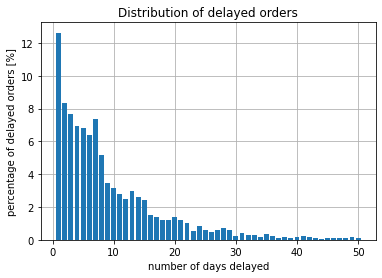

In [14]:
delayed_orders.createOrReplaceTempView("delayed_orders")
delayed_days = spark.sql("""
    SELECT days_delayed, COUNT(*) as no_orders FROM
        (SELECT *, DATEDIFF(order_delivered_customer_date, order_estimated_delivery_date) days_delayed FROM delayed_orders)
        GROUP BY days_delayed
        ORDER BY days_delayed
    ;
""")

x = delayed_days.select("days_delayed").rdd.flatMap(lambda _: _).collect()
y = delayed_days.select("no_orders").rdd.flatMap(lambda _: _).collect()

plt.grid(which="both")
plt.bar(x[:50], [100 * i / delayed_orders_count for i in y[:50]])
plt.title("Distribution of delayed orders")
plt.xlabel("number of days delayed")
plt.ylabel("percentage of delayed orders [%]")
plt.savefig("plots/task_1_distribution_of_delayed_orders.pdf")
plt.show()